<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/2_layer_Neural_Network_with_bp_by_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import datasets
import pandas as pd

import matplotlib.pyplot as plt

In [106]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

In [107]:
class Multilayer_Perceptron():
  def init_network_params(self, sizes, scale):
    rng = random.PRNGKey(0)
    keys = random.split(rng, len(sizes))
    params = []
    for m, n, key in zip(sizes[:-1], sizes[1:], keys):
      w_key, b_key = random.split(key)
      params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
    return params

  def __init__(self, model_sizes, weight_init=1e-2, num_classes=10, learning_rate= 0.001):
    self.params = self.init_network_params(model_sizes, scale=weight_init)
    self.num_classes = num_classes
    self.lr = learning_rate

  def sigmoid(self, x):
    return 1.0 / (1.0 + jnp.exp(-x))

  def forward(self, params, x):
    a = x
    for w, b in self.params[:-1]:
      z = jnp.dot(w, a) + b
      a = self.sigmoid(z)
    w_last, b_last = self.params[-1]
    logits = jnp.dot(w_last, a) + b_last
    return logits - logsumexp(logits)

  def batched_forward(self, x):
    batched_fw = vmap(self.forward, in_axes=(None, 0))
    return batched_fw(self.params, x)

  def loss(self, params, x, y):
    preds = self.batched_forward(x)
    return -jnp.mean(preds * y)

  @jit
  def update(self, params, x, y):
    grads = grad(self.loss)(params, x, y)
    return [(w - self.lr * dw, b - self.lr * db) for (w, b), (dw, db) in zip(params, grads)]

  
  def gradient_backpropagation(self, data, target):
    a1 = np.dot(data, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2

    error_fw = self.softmax(a2)
    error_softmax = (error_fw-target) / target.shape[0]

    grad_b2 = np.sum(error_softmax, axis=0)
    grad_w2 = np.dot(z1.T, error_softmax)

    error_l2 = np.dot(error_softmax, self.w2.T)
    error_sigmoid = error_l2*(1.-z1)*z1

    grad_b1 = np.sum(error_sigmoid, axis=0)
    grad_w1 = np.dot(data.T, error_sigmoid)

    return grad_w1, grad_w2, grad_b1, grad_b2

  def recognize(self, x):
    return jnp.argmax(self.forward(self.params, x))

In [ ]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(x, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(model.batched_forward(x), axis=1)
  return jnp.mean(predicted_class == target_class)

In [108]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [ ]:
mnist_dataset = MNIST('./dataset/mnist', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('./dataset/mnist', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

In [69]:
model = Multilayer_Perceptron([784, 512, 512, 10])
model.batched_forward(model.params[0][0])

DeviceArray([[-2.2714067, -2.1327438, -2.393264 , ..., -2.2512147,
              -2.2694113, -2.2728832],
             [-2.2714248, -2.132711 , -2.3932571, ..., -2.2512484,
              -2.26939  , -2.2729216],
             [-2.2714152, -2.1327415, -2.3932543, ..., -2.2512279,
              -2.2693994, -2.272916 ],
             ...,
             [-2.2714403, -2.1327167, -2.3932242, ..., -2.251214 ,
              -2.269385 , -2.2729   ],
             [-2.2714195, -2.1327279, -2.3932416, ..., -2.2512453,
              -2.2694154, -2.2728968],
             [-2.2714148, -2.132709 , -2.3932652, ..., -2.2512238,
              -2.2694273, -2.2729244]], dtype=float32)

In [99]:
x = random.randint(random.PRNGKey(1), (5,), minval=0, maxval=9)

In [103]:
jnp.array(x[:, None] ==jnp.arange(10), dtype=jnp.int32)

DeviceArray([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
             [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [51]:
for w, b in model.params[:-1]:
  print(w.shape, b.shape)

(512, 784) (512,)
(512, 512) (512,)


In [ ]:
data_tr_df = pd.read_csv("/content/sample_data/mnist_train_small.csv")
data_te_df = pd.read_csv("/content/sample_data/mnist_test.csv")
data_tr_df.rename(columns={data_tr_df.columns[0]: "target"}, inplace=True)
data_te_df.rename(columns={data_te_df.columns[0]: "target"}, inplace=True)
data_tr_la = np.array(data_tr_df['target'])
data_tr_ta = np.zeros([data_tr_la.size, 10])
for i in range(data_tr_la.size):
  data_tr_ta[i][data_tr_la[i]] = 1
data_tr_im = np.array(data_tr_df.drop(columns=['target']))
data_te_la = np.array(data_te_df['target'])
data_te_ta = np.zeros([data_te_la.size, 10])
for i in range(data_te_la.size):
  data_te_ta[i][data_te_la[i]] = 1
data_te_im = np.array(data_te_df.drop(columns=['target']))

In [ ]:
nn = neural_network(784, 100, 10, weight_init=0.01)
error = nn.train(data_tr_im, data_tr_ta, 0.01, 100000, batch=True)

In [ ]:
correct = 0
for i in range(data_te_ta.shape[0]):
  if data_te_ta[i][nn.recognize(data_te_im[i])] == 1:
    correct += 1
print("Accuracy: {:.2%}".format(correct / data_te_ta.shape[0]))

Accuracy: 10.09%


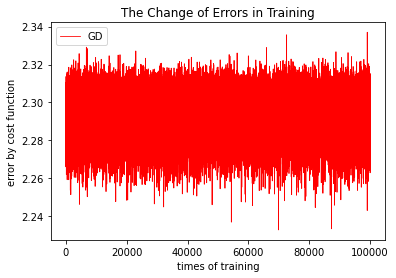

In [ ]:
times = np.arange(0, 100000, 1)
plt.figure("Training of naive neural network")
plt.title("The Change of Errors in Training")
plt.xlabel("times of training")
plt.ylabel("error by cost function")
plt.plot(times, error, 'r', label='GD', linewidth=0.8)
plt.legend()